Notebook is realized by *Volodymyr Motyka* and *Jaroslav Stepanyak*

___

We have HTTP requests and based on payloads of the requests we are detecting if it's an attack or not. <br>
We have three datasets: two of normal traffic and one of anomalous traffic. Anomalous traffic means there are some anomalies in HTTP request and we should consider it as a Web-Attack. <br>
A lot of Web-Attacks are based on manipulating payloads, so here we do the same.

The main problem is preprocessing data.

Preprocessing data consists of 2 steps:
1. Producing dictionary
2. Producing matrixes

More details below

___
First of all, import necessary modules and import anomalous data (only with anomalies) 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_data = pd.read_csv("anomalousTrafficTest.txt",sep="/n/n", header= None)
raw_data

C:\Users\Admin\AppData\Local\Temp\ipykernel_28428\3144564507.py:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data = pd.read_csv("anomalousTrafficTest.txt",sep="/n/n", header= None)


,0
0,GET http://localhost:8080/tienda1/publico/anad...
1,User-Agent: Mozilla/5.0 (compatible; Konqueror...
2,Pragma: no-cache
3,Cache-control: no-cache
4,"Accept: text/xml,application/xml,application/x..."
...,...
305641,"Accept-Charset: utf-8, utf-8;q=0.5, *;q=0.5"
305642,Accept-Language: en
305643,Host: localhost:8080
305644,Cookie: JSESSIONID=3CC12010CDA952F123240EBAD79...


We have realy bad data, so we need to clean it

The most important data are in rows, which starts with "GET"
So, we select only those rows and delete words "GET" and "HTTP/1.1"

After that, we have URL and their Payloads, we split them into two columns

In [2]:
URL_Payload = raw_data[raw_data[0].str.contains('GET') == True ]

URL_Payload.loc[:, 0] = URL_Payload[0].apply(lambda x: 
    x.replace("GET ", "").replace(" HTTP/1.1",""))
# Split the data at the '?' character
URL_Payload[['URL', 'payload']] = URL_Payload[0].str.split('?', expand=True)
URL_Payload = URL_Payload[['URL', 'payload']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_28428\4087905454.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  URL_Payload.loc[:, 0] = URL_Payload[0].apply(lambda x:
C:\Users\Admin\AppData\Local\Temp\ipykernel_28428\4087905454.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  URL_Payload[['URL', 'payload']] = URL_Payload[0].str.split('?', expand=True)
C:\Users\Admin\AppData\Local\Temp\ipykernel_28428\4087905454.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

The dictionary will be the filter for anomalous payloads. Keys are the anomalous payloads, values are the their counter in the dataset.<br>
Now import necessary modules for producing dictionary. 

In [3]:
import nltk
import re

In [4]:
# Initialize an empty dictionary
dict_filter = {}

# Iterate over the rows in the dataframe
for rdata in URL_Payload[URL_Payload['payload'].notna()].payload:
  # Tokenize the data using the '&' delimiter
  words = nltk.tokenize.regexp_tokenize(rdata, pattern=r"&", gaps=True)
  # Iterate over the words
  for word in words:
    # Check if the word is in the dictionary
    if word not in dict_filter:
      # If not, add it with a count of 1
      dict_filter[word] = 1
    else:
      # If it is, increment the count
      dict_filter[word] += 1

The dictionary looks like this: <br>
{'id=2': 375, <br>
 'nombre=Jam%F3n+Ib%E9rico': 318,<br>
 'precio=85': 334,<br>
 'cantidad=%27%3B+DROP+TABLE+usuarios%3B+SELECT+*+FROM+datos+WHERE+nombre+LIKE+%27%25': 3,<br>
 'B1=A%F1adir+al+carrito': 1192,<br>
 'id=2%2F': 46,<br>
 'cantidad=49': 7,<br>
 'modo=entrar': 1183,<br>
 'login=bob%40%3CSCRipt%3Ealert%28Paros%29%3C%2FscrIPT%3E.parosproxy.org': 5,<br>
 'pwd=84m3ri156': 2,<br>
 'remember=on': 554,<br>
 'B1=Entrar': 1173,<br>
 'login=grimshaw': 2,<br>
 'pwd=G%2F%2FlAc%2CIAr': 1,<br>
 'rememberA=on': 42,<br>
 'idA=2': 251,<br>
 ...

We've produced the dictionary dict_filter.
In the next step, we will use it as a filter.

This is the second step: matrixes production.
For that we produced function

The function produce_matrixs_df takes in two arguments: 'samples' and 'dict_filter'.

'samples' is a list of samples, and 'dict_filter' is a dictionary.

The function initializes an empty list called 'matrixs_df' to store the matrices that will be generated.

It then iterates over the samples list, and for each sample, it creates a matrix of zeros with dimensions (15000,). It tokenizes the sample using the '&' character as the delimiter, and creates a new dictionary called 'dict_v2' with keys corresponding to the tokenized elements and values of 1 if the element is in the dict_filter dictionary, or 0 otherwise.

The function then gets the keys of the 'dict_filter' dictionary and stores them in a list called 'dict_filter_keys'. It then iterates over the keys in 'dict_v2', and for each key, it searches for the corresponding index in the list of keys from 'dict_filter'. If a match is found, it sets the value of the matrix at this index to 1.

Finally, the function reshapes the matrix to dimensions (150,100) and appends it to the list of matrices, 'matrixs_df'.

Once all of the samples have been processed, the function returns the list of matrices, 'matrixs_df'.

In [9]:
def produce_matrixs_df(samples, dict_filter):
    # Initialize an empty list to store the matrices
    matrixs_df = []
    
    # Iterate over the samples
    for sample in samples:
        # Initialize a matrix of zeros with dimensions (15000,)
        matrix = np.zeros((15000))
        
        # Tokenize the sample using the '&' character as the delimiter
        sample_tokenized = nltk.tokenize.regexp_tokenize(sample, pattern=r"&", gaps=True)
        
        # Create a dictionary with keys corresponding to the tokenized elements
        # and values of 1 if the element is in the dict_filter dictionary, or 0 otherwise
        dict_v2 = {}
        for el in sample_tokenized:
            if el in dict_filter:
                dict_v2[el] = 1
            else:
                dict_v2[el] = 0
        
        # Get the keys of the dict_filter dictionary
        dict_filter_keys = list(dict_filter.keys())

        # Iterate over the keys in the new dictionary, and find the corresponding index in the list of keys from dict_filter
        for key in dict_v2.keys():
            for i, df_key in enumerate(dict_filter_keys):
                if key == df_key:
                    # Set the value of the matrix at this index to 1
                    matrix[i] = 1
                    
        # Reshape the matrix to dimensions (124, 124) and append it to the list of matrices
        matrixs_df.append(matrix.reshape(150,100))
    
    # Return the list of matrices
    return matrixs_df

The point of having matrixes is to use CNN model to detect Web-Attacks.<br>
Every pixel of the matrix has in correspondence the anomalous payload from the dict_filter

Upload data with normal traffic and preprocess them the same way we did it with data at the start

In [7]:
raw_data_norm_train = pd.read_csv("normalTrafficTraining.txt",sep="/n/n", header= None)
raw_data_norm_test = pd.read_csv("normalTrafficTest.txt",sep="/n/n", header= None)
raw_data_norm = pd.concat([raw_data_norm_train,raw_data_norm_test])

URL_Payload_norm = raw_data_norm[raw_data_norm[0].str.contains('GET') == True ]

URL_Payload_norm.loc[:, 0] = URL_Payload_norm[0].apply(lambda x: 
    x.replace("GET ", "").replace(" HTTP/1.1",""))
# Split the data at the '?' character
URL_Payload_norm[['URL', 'payload']] = URL_Payload_norm[0].str.split('?', expand=True)
URL_Payload_norm = URL_Payload_norm[['URL', 'payload']]

C:\Users\Admin\AppData\Local\Temp\ipykernel_28428\3543599310.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data_norm_train = pd.read_csv("normalTrafficTraining.txt",sep="/n/n", header= None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_28428\3543599310.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  raw_data_norm_test = pd.read_csv("normalTrafficTest.txt",sep="/n/n", header= None)
C:\Users\Admin\AppData\Local\Temp\ipykernel_28428\3543599310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

Produce matrix for every HTTP request of normal traffic. Then create dataframe and label them as all as 0 (which means there's no web-attack in the URL)

In [10]:
samples_ = URL_Payload_norm[URL_Payload_norm["payload"].notnull()]
samples_ = samples_["payload"]

res = produce_matrixs_df(samples_,dict_filter) 
df_norm = pd.DataFrame({'matrix': res, 'label': 0})

Produce matrix for every HTTP request of anomalous traffic. Then create dataframe and label them as all as 1 (which means there's a web-attack in the URL)

In [11]:
samples_ = URL_Payload[URL_Payload["payload"].notnull()]
samples_ = samples_["payload"]

res = produce_matrixs_df(samples_,dict_filter) 
df_anom = pd.DataFrame({'matrix': res, 'label': 1})

In [12]:
df = pd.concat([df_norm,df_anom])
df.reset_index(inplace=True)
df=df.drop('index',axis=1)

We have dataframe with labeled matrixes, we will use it for our CNN model

In [15]:
df

,matrix,label
0,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,...",0
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,...",0
2,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...
25604,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
25605,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
25606,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
25607,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1


In [11]:
df['matrix'][0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The following code is visualising a random matrix. White pixels represent anomalies, black pixels represent normal payloads 

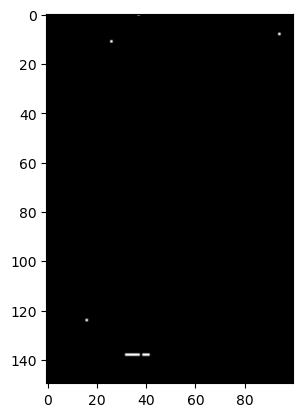

In [19]:
mat=np.asarray(df['matrix'][25000]).astype('float32')

plt.imshow(mat, cmap='gray')  
plt.show()

___
Here we are building our CNN, but before that we need to split our dataset into train and test datasets

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['matrix'], df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [21]:
X_train.shape

(20487,)

We cannot use the 'X_train' and 'X_test' for fitting any CNN model, we need to change shape of the variables

In [22]:
X_train = np.stack(X_train, axis=0)

# Add an additional dimension for the channels
X_train = np.expand_dims(X_train, axis=-1)

X_test = np.stack(X_test, axis=0)

# Add an additional dimension for the channels
X_test = np.expand_dims(X_test, axis=-1)

In [23]:
X_train.shape

(20487, 150, 100, 1)

Now, we're creating our CNN model

The structure of our model is similar to [LeNet](https://en.wikipedia.org/wiki/LeNet) neural network 


In [24]:
from tensorflow import keras
import itertools
import matplotlib.pyplot as plt

In [25]:
input_shape = (150, 100, 1)

In [29]:
model = keras.Sequential([
    keras.layers.Conv2D(16, (4,4),padding="same", activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D(pool_size=(4, 4)),
    keras.layers.Conv2D(16, (4,4),padding="same", activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(4, 4)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
history = model.fit(X_train, y_train, epochs=5)

Epoch 1/5
641/641 [==============================] - 27s 41ms/step - loss: 0.2264 - accuracy: 0.9131
Epoch 2/5
641/641 [==============================] - 27s 43ms/step - loss: 0.0758 - accuracy: 0.9735
Epoch 3/5
641/641 [==============================] - 27s 43ms/step - loss: 0.0522 - accuracy: 0.9823
Epoch 4/5
641/641 [==============================] - 34s 53ms/step - loss: 0.0403 - accuracy: 0.9857
Epoch 5/5
641/641 [==============================] - 38s 59ms/step - loss: 0.0340 - accuracy: 0.9893


Let's evaluate our model

161/161 [==============================] - 2s 14ms/step


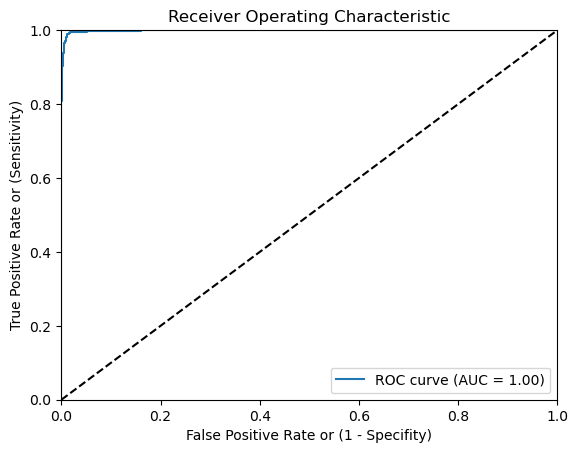

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3200
           1       0.98      0.98      0.98      1922

    accuracy                           0.99      5122
   macro avg       0.99      0.99      0.99      5122
weighted avg       0.99      0.99      0.99      5122



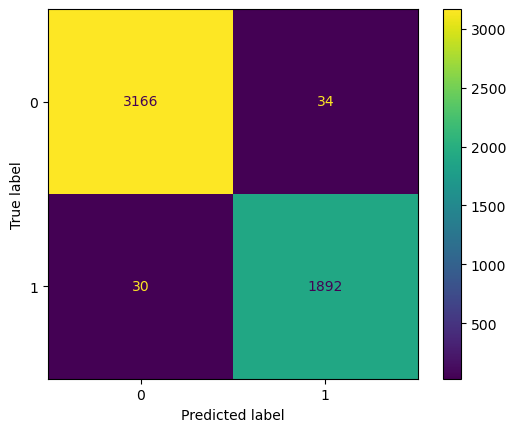

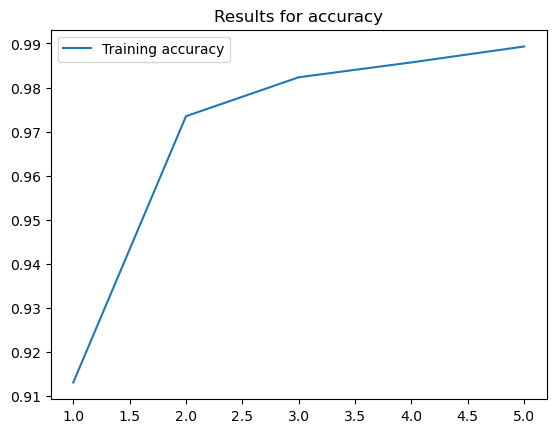

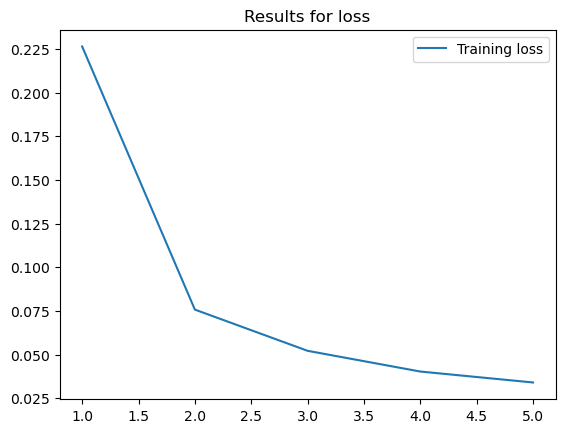

In [34]:
from keras.activations import softmax
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, classification_report

# Get the predicted probabilities for the test data
y_pred = model.predict(X_test)

y_pred_binary = np.round(y_pred)

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_binary)).plot()
print(classification_report(y_test, y_pred_binary))

for i in ['accuracy', 'loss']:
    acc = history.history[i]
    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='Training {}'.format(i))
    plt.title('Results for {}'.format(i))
    plt.legend()
    plt.show()